In [29]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset, DatasetDict, load_metric

In [30]:
current_directory=os.getcwd()

In [31]:
root_dir = os.path.join(current_directory,"custom_dataset")

In [32]:
ds = load_dataset("imagefolder", data_dir=root_dir)

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

In [33]:
ds = ds['train'].train_test_split(test_size=0.3, stratify_by_column="label")  # 70% train, 30% test
ds_test = ds['test'].train_test_split(test_size=0.5, stratify_by_column="label")  # 30% test --> 15% valid, 15% test
ds = DatasetDict({
    'train': ds['train'],
    'test': ds_test['test'],
    'valid': ds_test['train']
})

del ds_test

In [34]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 560
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 120
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 120
    })
})

In [35]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['Pattern', 'Soild'], id=None)

In [36]:
from PIL import Image
import torchvision.transforms as transforms

def transform(example_batch):
    # Define the desired image size
    desired_size = (224, 224)

    # Resize the images to the desired size
    resized_images = [transforms.Resize(desired_size)(x.convert("RGB")) for x in example_batch['image']]

    # Convert resized images to pixel values
    inputs = processor(resized_images, return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']

    return inputs

prepared_ds = ds.with_transform(transform)

In [37]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [38]:
from transformers import AutoImageProcessor, ViTForImageClassification

model_name_or_path = 'google/vit-base-patch16-224'

# Assuming 'labels' is a ClassLabel object, convert it to a list
labels_list = list(labels.names)

processor = AutoImageProcessor.from_pretrained(model_name_or_path, use_fast=True)
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels_list),
    id2label={str(i): c for i, c in enumerate(labels_list)},
    label2id={c: str(i) for i, c in enumerate(labels_list)},
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
from transformers import TrainingArguments

# root_dir = "/saved_model/"  # Path where all config files and checkpoints will be saved
root_dir = os.path.join(current_directory,"model_details")
training_args = TrainingArguments(
  output_dir=root_dir,
  per_device_train_batch_size=64,
  eval_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  num_train_epochs=300,
  logging_steps=500,
  learning_rate=2e-4,
  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [40]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["valid"],
    tokenizer=processor,
)

In [41]:
import torch 
save_dir = '/home/dev/workspace/Hugging_Face_Classifier/model_details/best_model/'  # Define the path to save the model
train_results = trainer.train()
trainer.save_model(save_dir)  # Save the best model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.411244,0.825000
2,No log,0.257957,0.900000
3,No log,0.232602,0.925000
4,No log,0.821823,0.858333
5,No log,0.323588,0.900000
6,No log,0.180874,0.950000
7,No log,0.186454,0.958333
8,No log,0.217398,0.950000
9,No log,0.249583,0.933333
10,No log,0.258079,0.933333


***** train metrics *****
  epoch                    =         300.0
  total_flos               = 12124566599GF
  train_loss               =        0.0024
  train_runtime            =    3:14:33.61
  train_samples_per_second =        14.391
  train_steps_per_second   =         0.231


In [42]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)


***** test metrics *****
  epoch                   =      300.0
  eval_accuracy           =       0.95
  eval_loss               =     0.2034
  eval_runtime            = 0:00:02.33
  eval_samples_per_second =     51.448
  eval_steps_per_second   =      6.431


Recall for Pattern: 0.92
Recall for Soild: 0.98


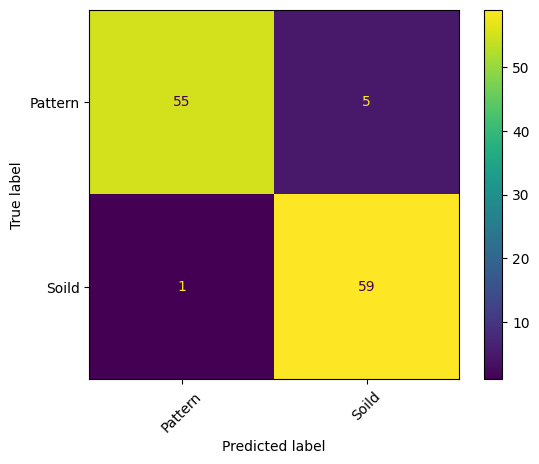

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

test_ds = ds['test'].with_transform(transform)
test_outputs = trainer.predict(test_ds)

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

labels = test_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
  print(f"Recall for {label}: {score:.2f}")

In [45]:
from transformers import pipeline, AutoImageProcessor, ViTForImageClassification
import matplotlib.pyplot as plt

def getPrediction(image):
    model_name_or_path = 'google/vit-base-patch16-224'
    processor = AutoImageProcessor.from_pretrained(model_name_or_path)
    vit = ViTForImageClassification.from_pretrained(save_dir)
    model = pipeline('image-classification', model=vit, feature_extractor=processor)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    pil_image = Image.fromarray(image)
    
    plt.imshow(pil_image)
    plt.axis('off')  # Hide the axis
    plt.show()
    
    result = model(pil_image)
    return result


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


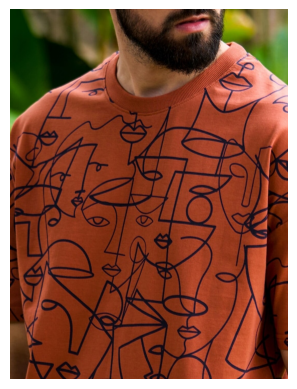

[{'label': 'Pattern', 'score': 0.9414638876914978}, {'label': 'Soild', 'score': 0.058536089956760406}]
Prediction : Pattern


In [46]:
import cv2

image = cv2.imread("/home/dev/workspace/Hugging_Face_Classifier/custom_dataset_1/pattern/d386555f-dda7-4d32-8597-f40f06b6051b.jpeg")
# print(image)
result=getPrediction(image)
print(result)
pattern_score = result[0]['score']
solid_score = result[1]['score']

# Compare scores and determine the result
if pattern_score > solid_score:
    final_result = result[0]['label']
else:
    final_result = result[1]['label']
    
print(f"Prediction : {final_result}")



# print(getPrediction(image))


In [47]:
from transformers import AutoImageProcessor, ViTForImageClassification

save_dir = '/home/dev/workspace/Hugging_Face_Classifier/model_details/best_model/Saved'

model.save_pretrained(save_dir)

processor.save_pretrained(save_dir)

['/home/dev/workspace/Hugging_Face_Classifier/model_details/best_model/Saved/preprocessor_config.json']

In [49]:
from transformers import TFAutoModelForImageClassification, AutoImageProcessor, ViTForImageClassification
import tensorflow as tf
import os

model_name_or_path = '/home/dev/workspace/Hugging_Face_Classifier/model_details/best_model/'
processor = AutoImageProcessor.from_pretrained(model_name_or_path)
pt_model = ViTForImageClassification.from_pretrained(model_name_or_path)

tf_model = TFAutoModelForImageClassification.from_pretrained(model_name_or_path, from_pt=True)

save_dir_tf = '/home/dev/workspace/Hugging_Face_Classifier/model_details/tf_model/'
os.makedirs(save_dir_tf, exist_ok=True)

tf.saved_model.save(tf_model, save_dir_tf)

if os.path.exists(save_dir_tf):
    print("Directory exists.")
    if os.path.exists(os.path.join(save_dir_tf, 'saved_model.pb')):
        print("SavedModel file exists.")
    else:
        print("SavedModel file does not exist.")
else:
    print("Directory does not exist.")

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


INFO:tensorflow:Assets written to: /home/dev/workspace/Hugging_Face_Classifier/model_details/tf_model/assets


INFO:tensorflow:Assets written to: /home/dev/workspace/Hugging_Face_Classifier/model_details/tf_model/assets


Directory exists.
SavedModel file exists.


In [50]:
# Convert the model to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_saved_model(save_dir_tf)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the quantized model
quantized_model_path = '/home/dev/workspace/Hugging_Face_Classifier/model_details/tf_model_quantized.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Quantized model saved at {quantized_model_path}")

2024-07-25 11:41:49.543864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-07-25 11:41:49.543920: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-07-25 11:41:49.544604: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /home/dev/workspace/Hugging_Face_Classifier/model_details/tf_model/
2024-07-25 11:41:49.578843: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-07-25 11:41:49.579827: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /home/dev/workspace/Hugging_Face_Classifier/model_details/tf_model/
2024-07-25 11:41:49.649258: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-07-25 11:41:49.693082: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-07-25 11:41:50.357838: I tensorflow/cc/saved

Quantized model saved at /home/dev/workspace/Hugging_Face_Classifier/model_details/tf_model_quantized.tflite
